In [5]:
from datetime import datetime 
from pathlib import Path
import json
import numpy as np
import torch
from torch import Tensor
import pandas as pd
from shutil import copyfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from common import haversine_cluster, str_contains_sub, haversine_np, RADIUS_EARTH_KM, normalize_lat_long
from models import MlpTriangulationModel, mmles_np
from loss import DisMaxLossSecondPart
from calibration import get_calibrated_temperature
from uncertainty import ECELoss

In [6]:
# df = pd.read_csv("data/mappers_processed.csv")
# df = pd.read_csv("data/mappers_processed_20230212-154020.csv")
df = pd.read_csv("data/mappers_processed_20240204-192113.csv")
if "id" in df.columns:
    df = df.drop(["id"], axis=1)

In [7]:
# fpath_clusters = "data/clusters_sfbay_20230212-162244.csv"
fpath_clusters = "data/clusters_sfbay_20240204-192422.csv"
df_clusters = pd.read_csv(fpath_clusters)

In [8]:
# Limit data points to those that fall within the clusterable regions
lat_bounds = [df_clusters["cluster_lat"].min(), df_clusters["cluster_lat"].max()]
long_bounds = [df_clusters["cluster_long"].min(), df_clusters["cluster_long"].max()]

for prefix in {"target", "hotspot1", "hotspot2", "hotspot3"}:
    df = df[df[f"{prefix}_lat"] > min(lat_bounds)]
    df = df[df[f"{prefix}_lat"] < max(lat_bounds)]
    df = df[df[f"{prefix}_long"] > min(long_bounds)]
    df = df[df[f"{prefix}_long"] < max(long_bounds)]

In [9]:
df.shape

(401436, 28)

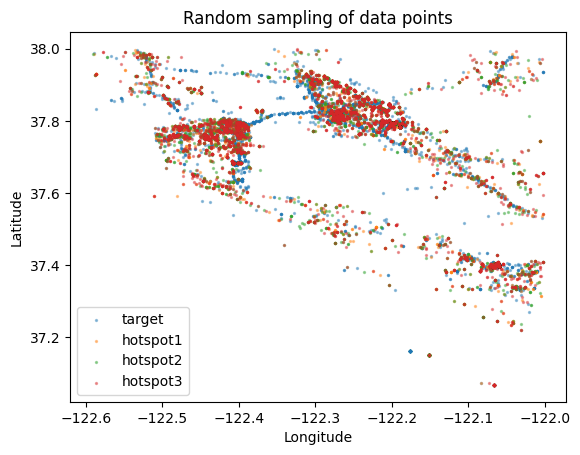

In [10]:
subset = df.sample(n=min(len(df), 5000))
for prefix in ["target"] + [f"hotspot{i}" for i in range(1,4)]:
    plt.scatter(subset[f"{prefix}_long"], subset[f"{prefix}_lat"], s=2, alpha=0.4, label=f"{prefix}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Random sampling of data points")
plt.legend()

In [11]:
if "naive_tri_alt" in df.columns:
    df = df.rename(columns={"naive_tri_alt": "naive_tri_altitude"})

In [12]:
# Add cluster assignments and their normalized values
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    # Assign a cluster_id
    df[f"{prefix}_cluster_id"] = haversine_cluster(
        points_lat_long_deg=df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy(),
        centroids_lat_long_deg=df_clusters[["cluster_lat", "cluster_long"]].to_numpy(),
        trace=True,
    )
    # normalize cluster_id
    df[f"{prefix}_cluster_id_norm"] = 2 * df[f"{prefix}_cluster_id"] / (len(df_clusters) - 1) - 1

100%|██████████| 3347/3347 [00:32<00:00, 103.52it/s]


In [13]:
# Add normalized lat, long
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    df[[f"{prefix}_lat_norm", f"{prefix}_long_norm"]] = normalize_lat_long(
        lat_long_deg=df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy()
    )

In [14]:
# Split the data into train and test with 80 train / 20 test
df_train, df_val = train_test_split(df, test_size=0.2, random_state = 1, shuffle=True)

In [15]:
label_cols = ["target_cluster_id"]
naive_tri_cols = ["naive_tri_cluster_id"]
sample_cols = [
        'naive_tri_cluster_id_norm', 'centroid_projected_cluster_id_norm', 'hotspot1_cluster_id_norm', 'hotspot2_cluster_id_norm', 'hotspot3_cluster_id_norm', 
        'centroid_projected_lat_norm', 'centroid_projected_long_norm',
        'hotspot1_lat_norm', 'hotspot1_long_norm', 
        'hotspot2_lat_norm', 'hotspot2_long_norm', 
        'hotspot3_lat_norm', 'hotspot3_long_norm', 
        'hotspot1_rssi', 'hotspot2_rssi', 'hotspot3_rssi', 
        'hotspot1_snr', 'hotspot2_snr','hotspot3_snr',
        # 'hotspot1_fspl_dist_km', 'hotspot2_fspl_dist_km', 'hotspot3_fspl_dist_km',
        'naive_tri_lat_norm', 'naive_tri_long_norm',
]

y_train = df_train[label_cols].to_numpy()
y_val_cluster = df_val[label_cols].to_numpy()
y_val_ll = df_val[["target_lat", "target_long"]].to_numpy()
y_val_naive_cluster = df_val[naive_tri_cols].to_numpy()
y_val_naive_ll = df_val[["naive_tri_lat", "naive_tri_long"]].to_numpy()

print(y_train.shape)
print(y_train.min(axis=0))
print(y_train.max(axis=0))
print(y_val_cluster.shape)
print(y_val_cluster.min(axis=0))
print(y_val_cluster.max(axis=0))

(321148, 1)
[1]
[3346]
(80288, 1)
[3]
[3344]


In [16]:

x_train = df_train[sample_cols].to_numpy()
x_val = df_val[sample_cols].to_numpy()

# Normalize all features to expected range -1:1 based on consideration of the training data alone
X_TRAIN_MIN = x_train.min(axis=0)
X_TRAIN_RANGE = x_train.ptp(axis=0)

for i, s in enumerate(sample_cols):
    # Avoid re-normalizing anything that was already normalized
    if str_contains_sub(s, ["_norm"]):
        continue
    print(f"Normalizing: {s}...")
    x_train[:, i] = 2 * (x_train[:, i] - X_TRAIN_MIN[i]) / X_TRAIN_RANGE[i] - 1
    x_val[:, i] = 2 * (x_val[:, i] - X_TRAIN_MIN[i]) / X_TRAIN_RANGE[i] - 1

print(x_train.shape)
print(x_train.min(axis=0))
print(x_train.max(axis=0))
print(x_val.shape)
print(x_val.min(axis=0))
print(x_val.max(axis=0))

Normalizing: hotspot1_rssi...
Normalizing: hotspot2_rssi...
Normalizing: hotspot3_rssi...
Normalizing: hotspot1_snr...
Normalizing: hotspot2_snr...
Normalizing: hotspot3_snr...
(321148, 21)
[-0.99940227 -0.99940227 -0.99940227 -0.99940227 -0.99940227  0.4117517
 -0.68105594  0.4116973  -0.68106505  0.41169596 -0.68106505  0.41169596
 -0.68111547 -1.         -1.         -1.         -1.         -1.
 -1.          0.41175212 -0.68105576]
[ 1.          1.          1.          1.          1.          0.42219606
 -0.67779093  0.4222181  -0.67777814  0.4222181  -0.67777814  0.42221784
 -0.67777814  1.          1.          1.          1.          1.
  1.          0.42219604 -0.67779097]
(80288, 21)
[-0.99760909 -0.99760909 -0.99880454 -0.99880454 -0.99880454  0.41189941
 -0.6810396   0.41186182 -0.68105664  0.41186182 -0.68106505  0.41186182
 -0.68106505 -0.98461538 -0.98130841 -0.95402299 -0.92265195 -0.98333338
 -1.01156074  0.41189845 -0.68104014]
[ 1.          1.          1.          1.    

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


In [18]:
torch.manual_seed(42)

Xtr, Ytr = torch.tensor(x_train).float().to(device), torch.tensor(y_train).to(device)
Xval, Yval = torch.tensor(x_val).float().to(device), torch.tensor(y_val_cluster).to(device)
Yval_NAIVE = torch.tensor(y_val_naive_cluster).float().to(device)

def get_batch(batch_size:int =32, is_train: bool=True):
    # generate a small batch of data of inputs x and targets y
    src_data = Xtr if is_train else Xval
    labels = Ytr if is_train else Yval
    ix = torch.randint(0, src_data.shape[0], (batch_size,))
    return src_data[ix], labels[ix].squeeze()

In [19]:
model = MlpTriangulationModel(
    input_size = x_train.shape[-1], # number of channels/features in each input sample
    output_size = len(df_clusters), # number of predictable clusters
    hidden_layer_size=128,
    n_hidden_layers=5,
)
model.to(device)

# This will replace the cross entropy loss
criterion = DisMaxLossSecondPart(model.classifier)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Create optimizer
init_lr = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

0.497922 M parameters


In [20]:
# Find a good learning rate
if False:
    lri = []
    lossi = []
    lre = torch.linspace(-6, -2, 1000)
    lrs = 10**lre
    BATCH_SIZE = 256
    for i, lr in enumerate(lrs):
        for g in optimizer.param_groups:
            g['lr'] = lr
        # Get a random batch
        Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

        # Predict coordinates and evaluate loss
        outputs = model(Xb)
        loss = criterion(outputs, Yb.squeeze())
        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        lri.append(lr.item())
        lossi.append(loss.item())

    plt.plot(lri, lossi)
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")

In [21]:
naive_val_acc = (Yval.squeeze() == Yval_NAIVE.squeeze()).sum().item()/Yval.size(0)
print(f"NAIVE Trilat Val Cluster Cls Acc: {100*naive_val_acc:.2f}%")

NAIVE Trilat Val Cluster Cls Acc: 4.01%


In [22]:
def get_outputs_labels_and_metrics(model, data:Tensor, labels:Tensor):
    model.eval()
    ece_criterion = ECELoss()
    nll_criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        logits = model(data)
        output_probs = torch.nn.functional.softmax(logits,dim=1)
        _, predicted = torch.max(output_probs, 1)
    acc = 100 * (predicted == labels).sum().item() / labels.size(0)
    nll = nll_criterion(logits, labels).item()
    ece = ece_criterion.loss(logits.cpu().numpy(), labels.cpu().numpy(), 15)

    return {
        'outputs': logits,
        'labels': labels,
        'acc': acc,
        'nll': nll,
        'ece': ece
    }

In [23]:
# Training
BATCH_SIZE = 256
MAX_STEPS = 15000
LR_DECAY = [6000, 12000]
PRINT_INTERVAL = MAX_STEPS // 15
stats = []

lr = init_lr
for i in range(MAX_STEPS):
    model.train()
    # Get a random batch
    Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

    # Predict coordinates and evaluate loss
    outputs = model(Xb)
    loss = criterion(outputs, Yb.squeeze())

    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    step_stats = {
        "step": i,
        "loss": loss.item(),
        "lr": lr
    }
    if i % PRINT_INTERVAL == 0:
        results = get_outputs_labels_and_metrics(model, data=Xval, labels=Yval.squeeze())
        acc = results["acc"]
        ece = results["ece"]
        step_stats["val_cluster_classification_accuracy"] = acc
        step_stats["ece"] = ece
        step_stats["nll"] = results["nll"]
        print(f"Step: {i},\t Loss: {loss.item():.6f},\t [Cluster Classification] Acc: {acc:.2f}%, ECE: {ece: .2f}")
        # with torch.no_grad():
        #     classification_accuracy = eval_accuracy(data=Xval, labels=Yval.squeeze())
        #     step_stats["val_cluster_classification_accuracy"] = classification_accuracy
        # print(f"Step: {i},\t Loss: {loss.item():.6f},\tVal Cluster Cls Acc: {100*classification_accuracy:.2f}%")
    if i in LR_DECAY:
        print("Adjusting LR")
        for g in optimizer.param_groups:
            lr = lr * 0.1
            g['lr'] *= 0.1
    stats.append(step_stats)


Step: 0,	 Loss: 8.140618,	 [Cluster Classification] Acc: 0.02%, ECE:  0.00
Step: 1000,	 Loss: 2.842726,	 [Cluster Classification] Acc: 28.37%, ECE:  0.28
Step: 2000,	 Loss: 2.273701,	 [Cluster Classification] Acc: 28.01%, ECE:  0.28
Step: 3000,	 Loss: 2.368205,	 [Cluster Classification] Acc: 18.56%, ECE:  0.18
Step: 4000,	 Loss: 1.942020,	 [Cluster Classification] Acc: 26.63%, ECE:  0.27
Step: 5000,	 Loss: 1.859806,	 [Cluster Classification] Acc: 29.79%, ECE:  0.30
Step: 6000,	 Loss: 1.984545,	 [Cluster Classification] Acc: 13.82%, ECE:  0.14
Adjusting LR
Step: 7000,	 Loss: 1.841017,	 [Cluster Classification] Acc: 58.12%, ECE:  0.58
Step: 8000,	 Loss: 1.852901,	 [Cluster Classification] Acc: 57.78%, ECE:  0.58
Step: 9000,	 Loss: 1.747430,	 [Cluster Classification] Acc: 57.27%, ECE:  0.57
Step: 10000,	 Loss: 1.631468,	 [Cluster Classification] Acc: 57.34%, ECE:  0.57
Step: 11000,	 Loss: 1.513839,	 [Cluster Classification] Acc: 58.19%, ECE:  0.58
Step: 12000,	 Loss: 1.561938,	 [Cluster C

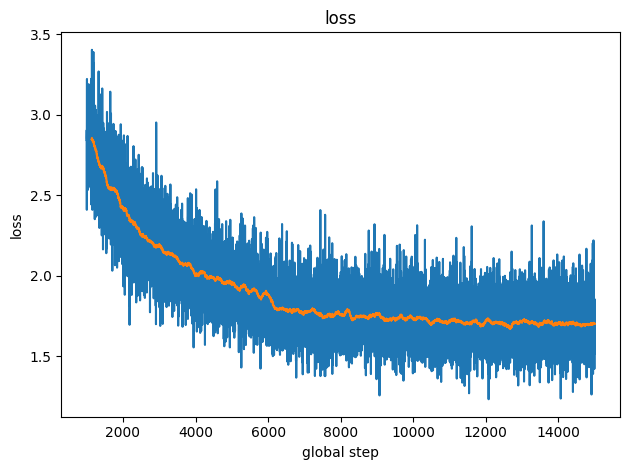

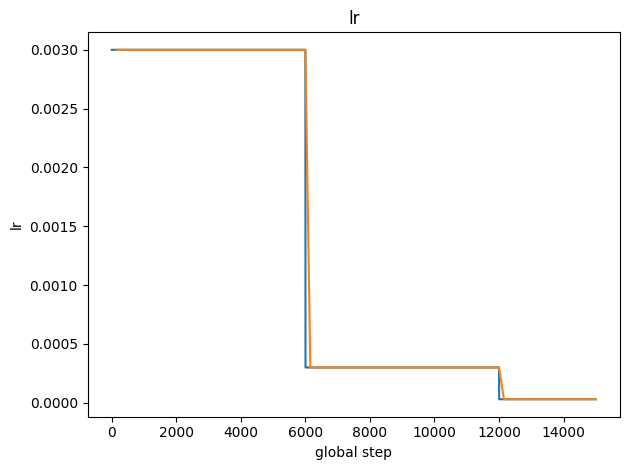

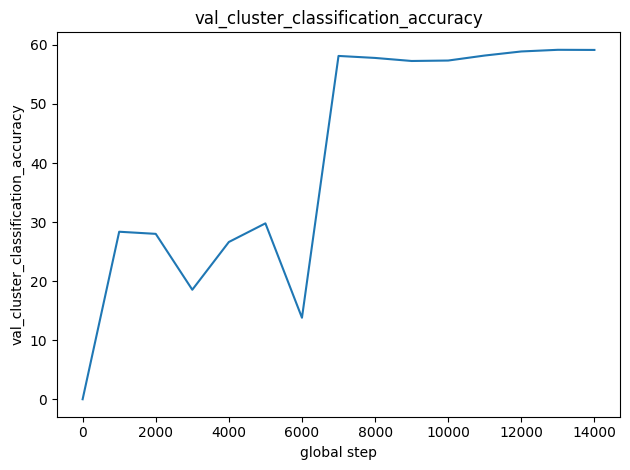

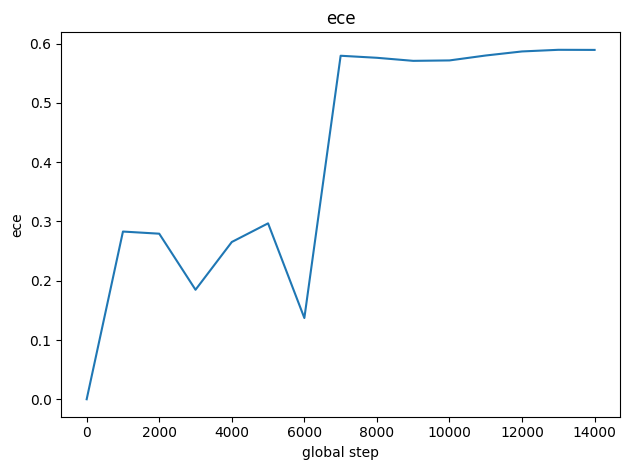

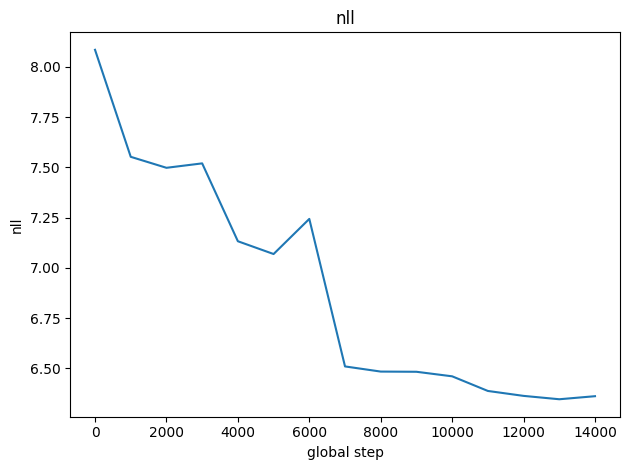

In [24]:
plot_contents = {}
for i, step_stats in enumerate(stats):
    step = step_stats.get("step", i)
    for k, v in step_stats.items():
        if k == "step":
            continue
        if k not in plot_contents:
            plot_contents[k] = {"x": [], "y":[]}
        plot_contents[k]["x"].append(step)
        plot_contents[k]["y"].append(v)
for k, v in plot_contents.items():
    x, y = np.asarray(v["x"]), np.asarray(v["y"])
    if k == "loss":
        x = x[1000:]
        y = y[1000:]
    plt.figure()
    plt.title(k)
    plt.plot(x,y)
    n = y.shape[0] // 100
    if n > 10:
        smoothed = np.convolve(y, np.ones(n), 'valid') / n
        smoothed = np.average(np.lib.stride_tricks.sliding_window_view(y, n), axis=1)
        plt.plot(x[n-1:], smoothed, label="Smoothed")
    plt.xlabel("global step")
    plt.ylabel(k)
    plt.tight_layout()

# Calibrate

In [25]:
# Calibrate the temperature for the model, optimizing ECE metric
results = get_outputs_labels_and_metrics(model, data=Xval, labels=Yval.squeeze())
logits = results["outputs"].cpu().numpy()
labels = results["labels"].cpu().numpy()
temperature_for_min_ece = get_calibrated_temperature(logits, labels)
print(temperature_for_min_ece)
model.classifier.temperature.data = torch.tensor([temperature_for_min_ece]).to(device) 

0.09863392838133916


# Export

In [27]:
# Save everything needed for inference
now_str = datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir = Path("models") / now_str
output_dir.mkdir(exist_ok=False)

# Save the clusters csv
copyfile(fpath_clusters, output_dir/"clusters.csv")

# Save the model
torch.save(model, output_dir/"model.pth")

# Save training stats
with open(output_dir/"training_stats.json", "w") as f:
    json.dump(stats, f)

# Save metadata
with open(output_dir/"metadata.json", "w") as f:
    json.dump({
       "zone": {
            "latitude": {
                "min": min(lat_bounds),
                "max": max(lat_bounds)
            },
            "longitude": {
                "min": min(long_bounds),
                "max": max(long_bounds)
            }
       },
       "model": {
            "output_features": label_cols,
            "input_features": sample_cols, 
            "input_normalization": {
                "input_features_min": list(X_TRAIN_MIN),
                "input_features_range": list(X_TRAIN_RANGE),
            }
       },
    }, f)

# Inference

In [28]:
# Reload the model from disk
model = torch.load(output_dir/"model.pth")
model.to(device)


MlpTriangulationModel(
  (classifier): DisMaxLossFirstPart(num_features=128, num_classes=3347)
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=21, out_features=128, bias=False)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=False)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=128, bias=False)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=128, bias=False)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=128, bias=False)
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1

In [29]:
model.eval()
with torch.no_grad():
    logits = model(Xval)
    softmax_scores = model.get_softmax_scores_for_logits(logits)

logits = logits.cpu().numpy()
softmax_scores = softmax_scores.cpu().numpy()
mmles_scores = mmles_np(logits)

In [30]:
predicted_cluster_idxs = softmax_scores.argmax(axis=1).squeeze()
confidence = softmax_scores.max(axis=1)

is_correct = predicted_cluster_idxs == Yval.squeeze().cpu().numpy()
print(sum(is_correct)/is_correct.shape[0])

predicted_lat_long = df_clusters[["cluster_lat", "cluster_long"]].to_numpy()[predicted_cluster_idxs, :]
dist_err_km = haversine_np(
    predicted_lat_long, 
    y_val_ll, 
    radius=RADIUS_EARTH_KM
)
naive_tri_dist_err_km = haversine_np(
    y_val_naive_ll, 
    y_val_ll, 
    radius=RADIUS_EARTH_KM
)

0.5931646074133121


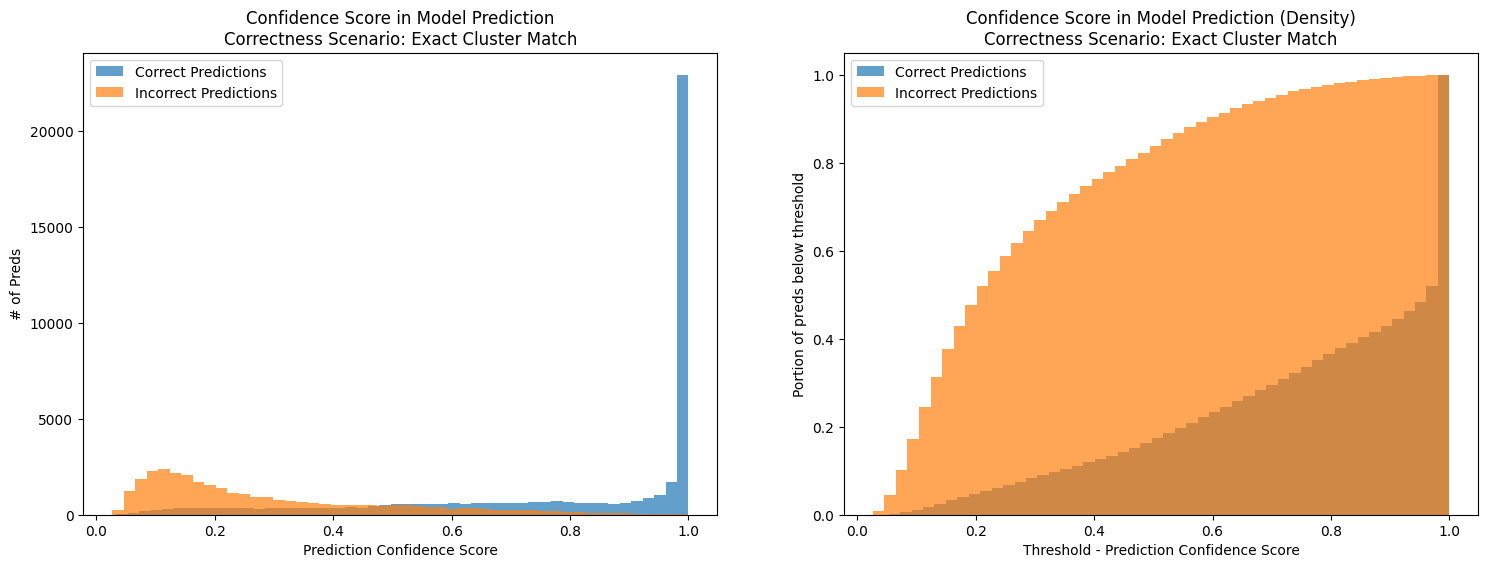

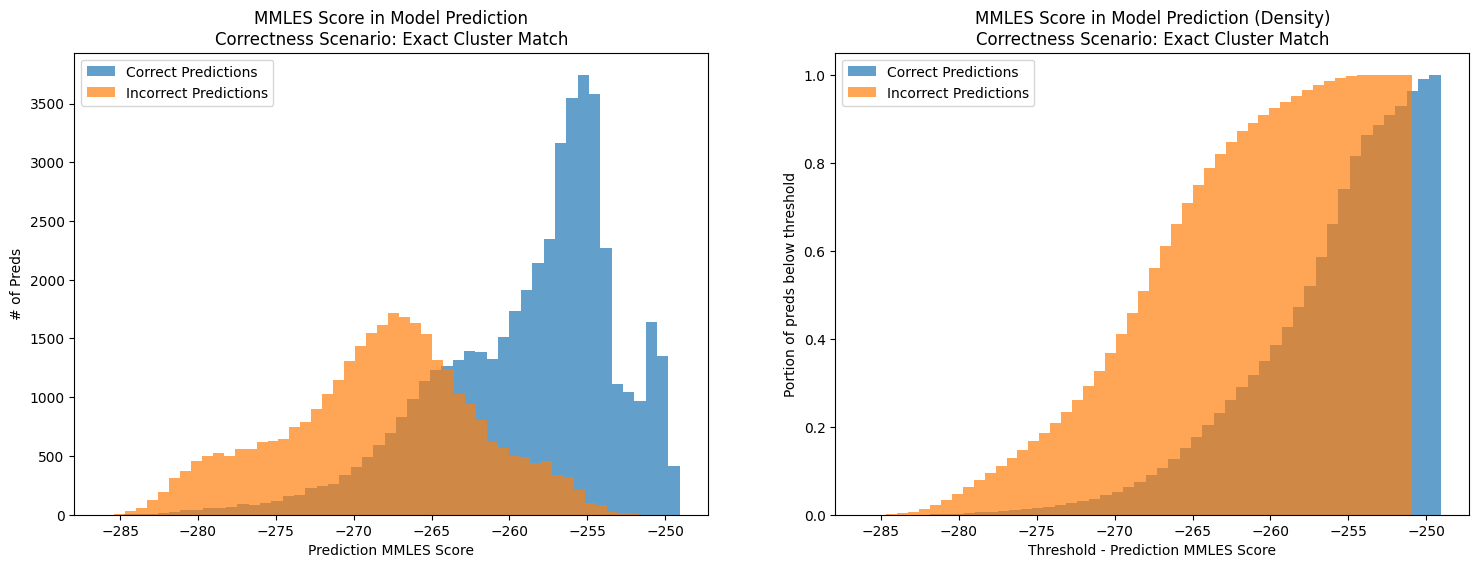

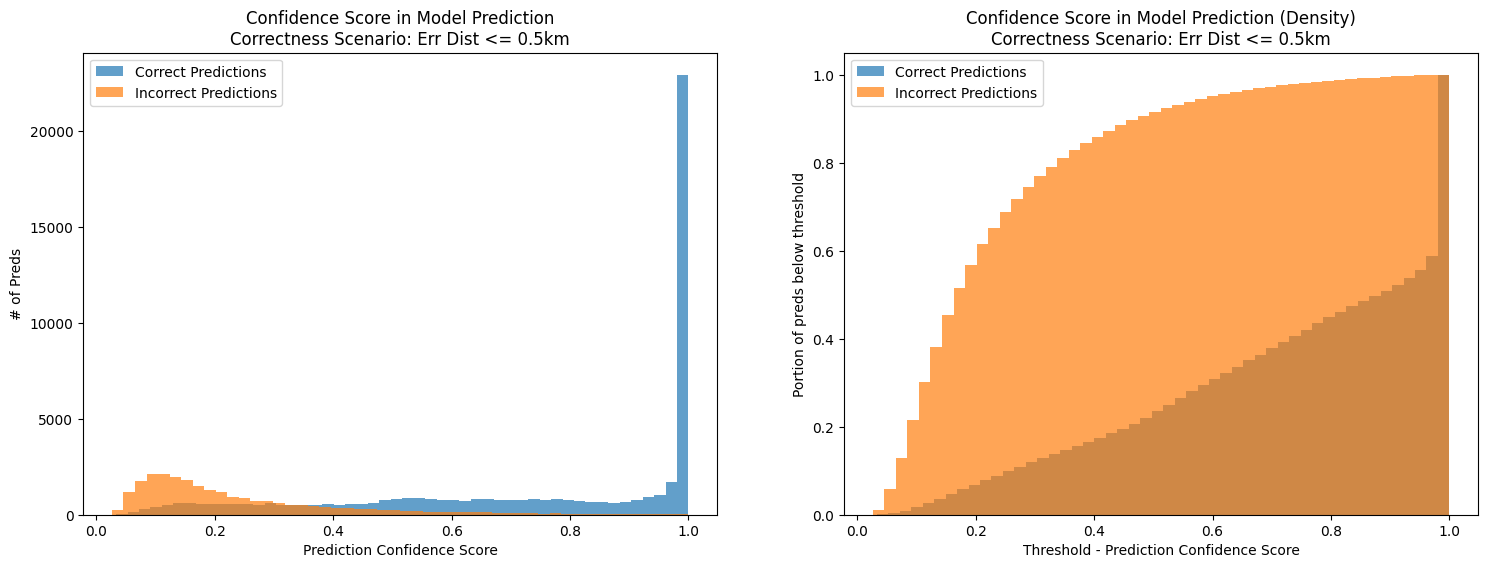

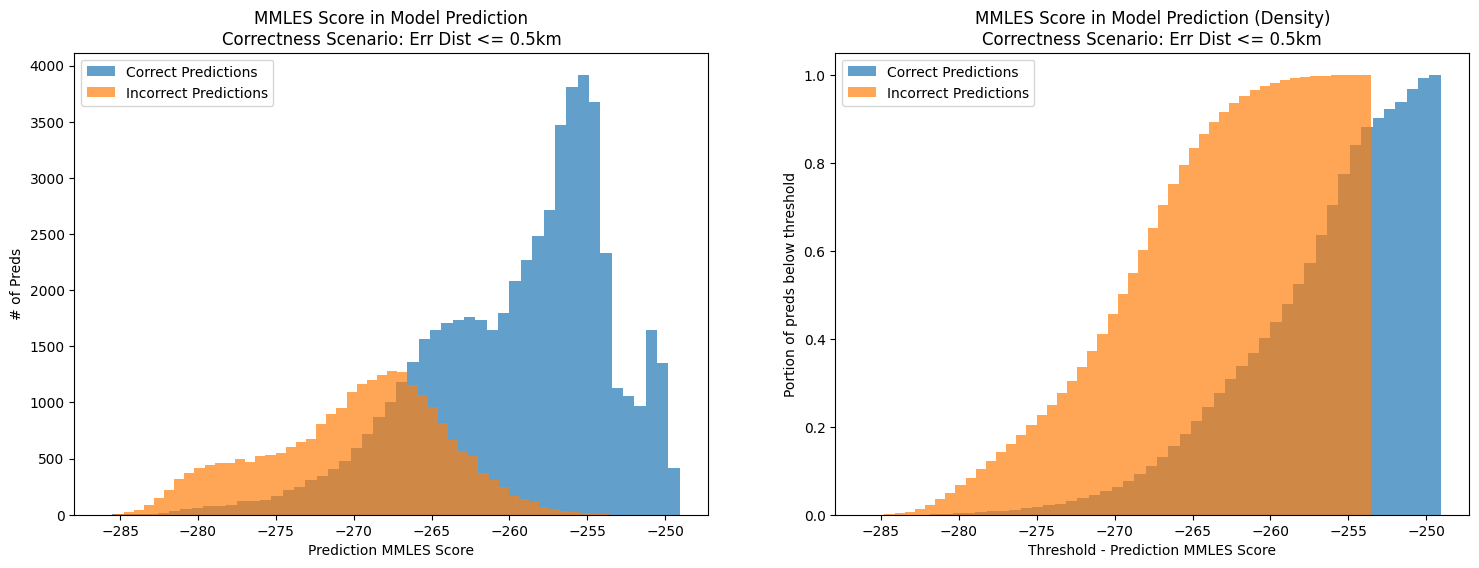

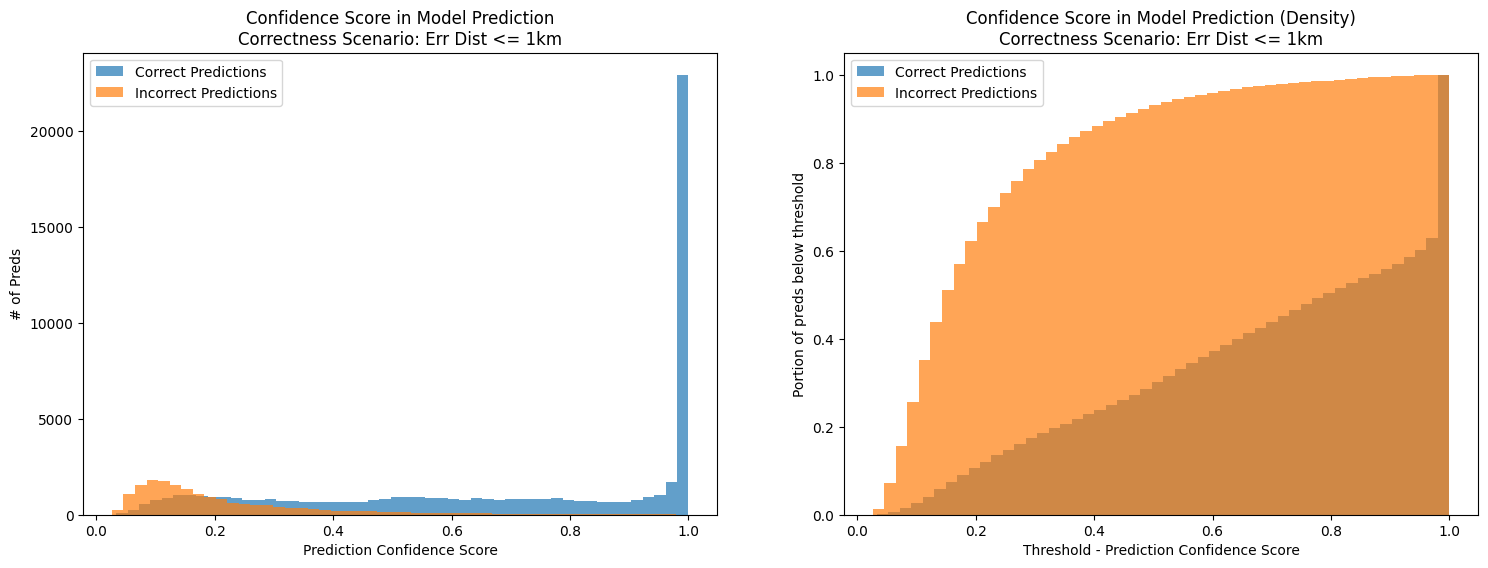

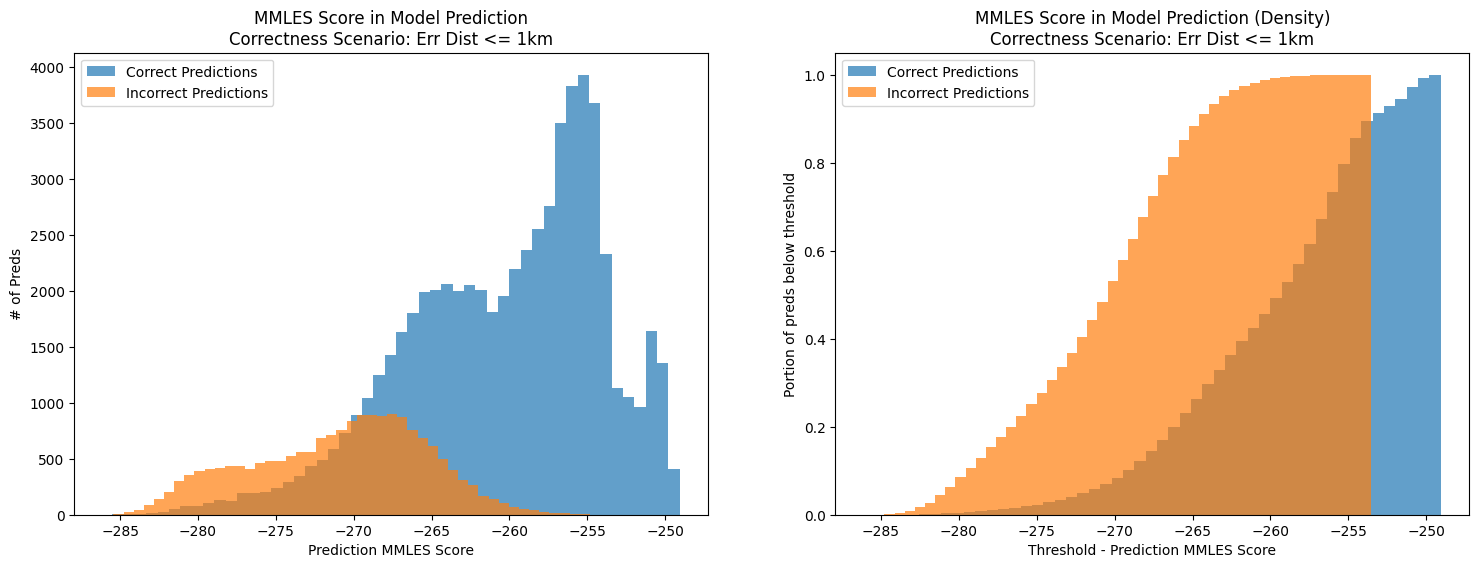

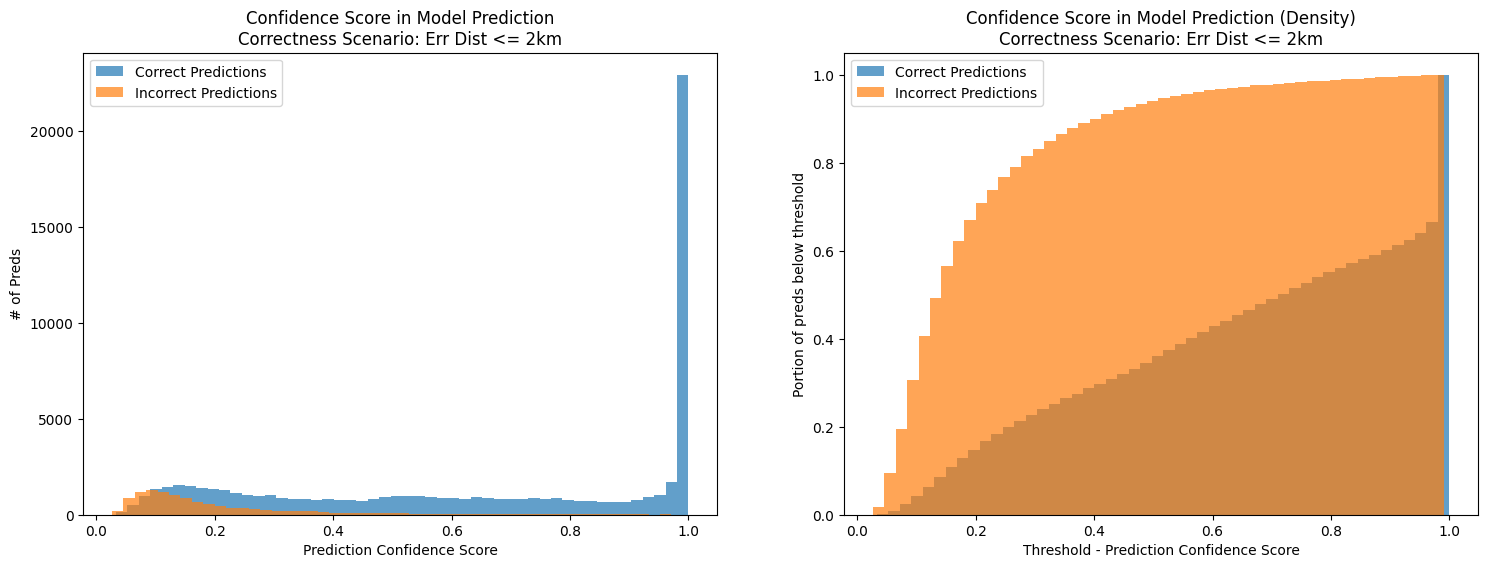

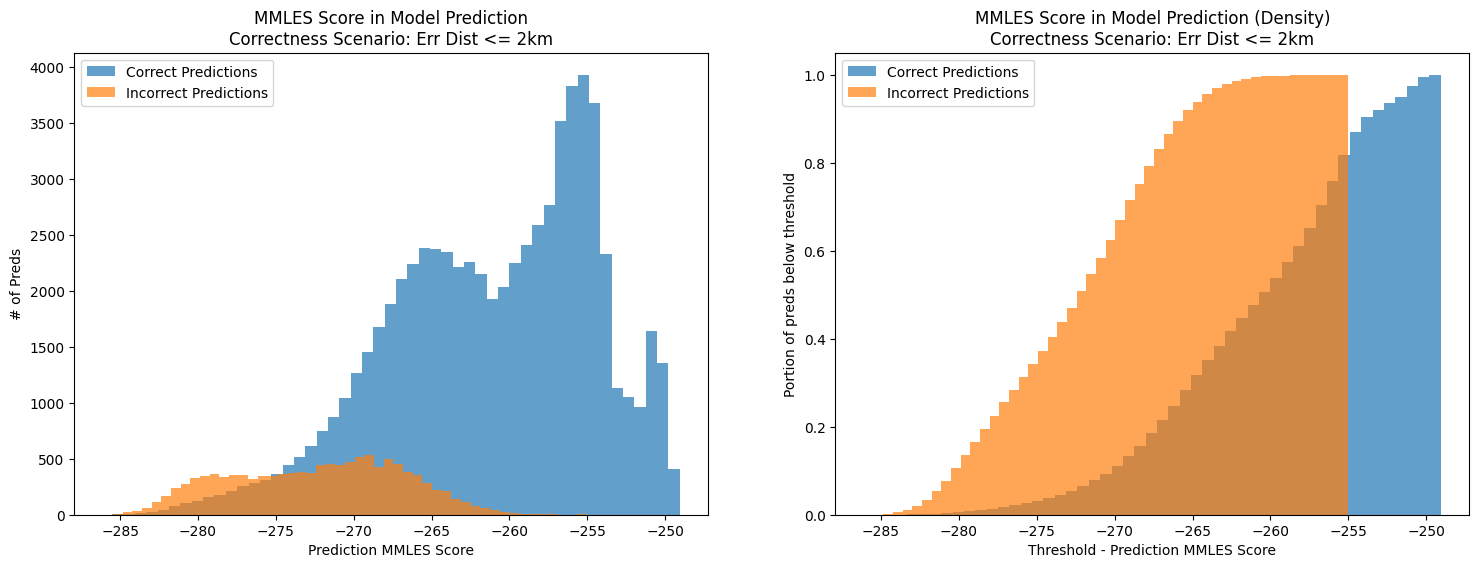

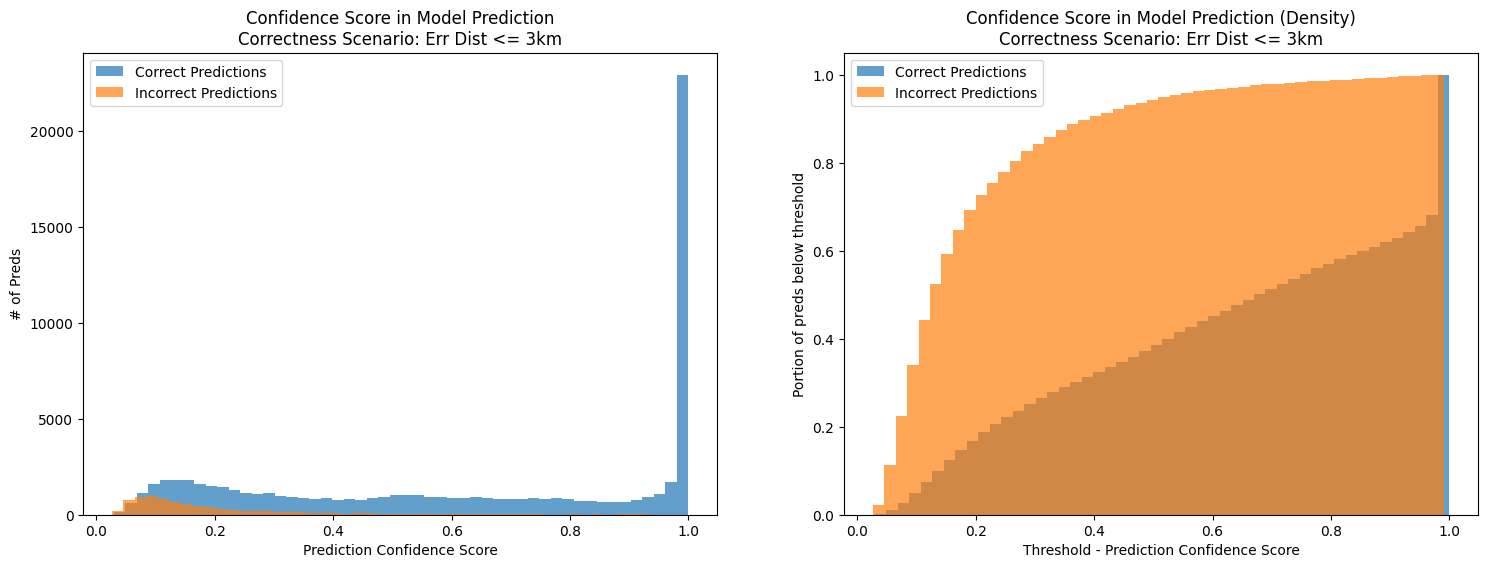

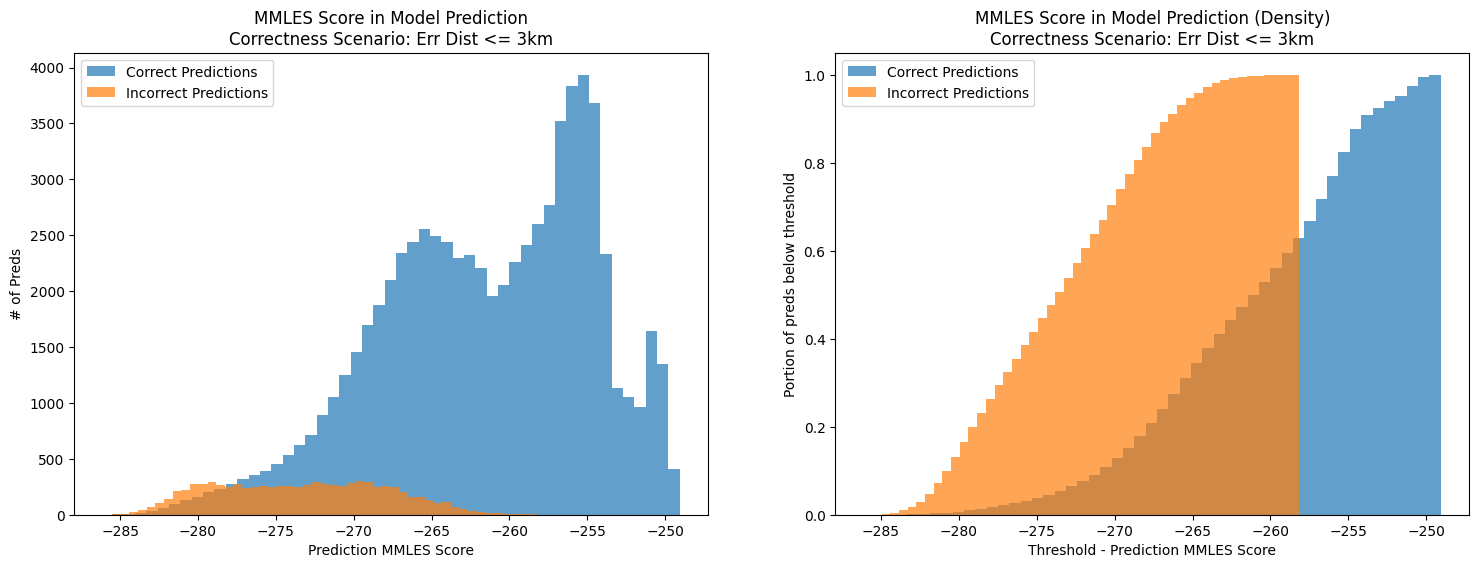

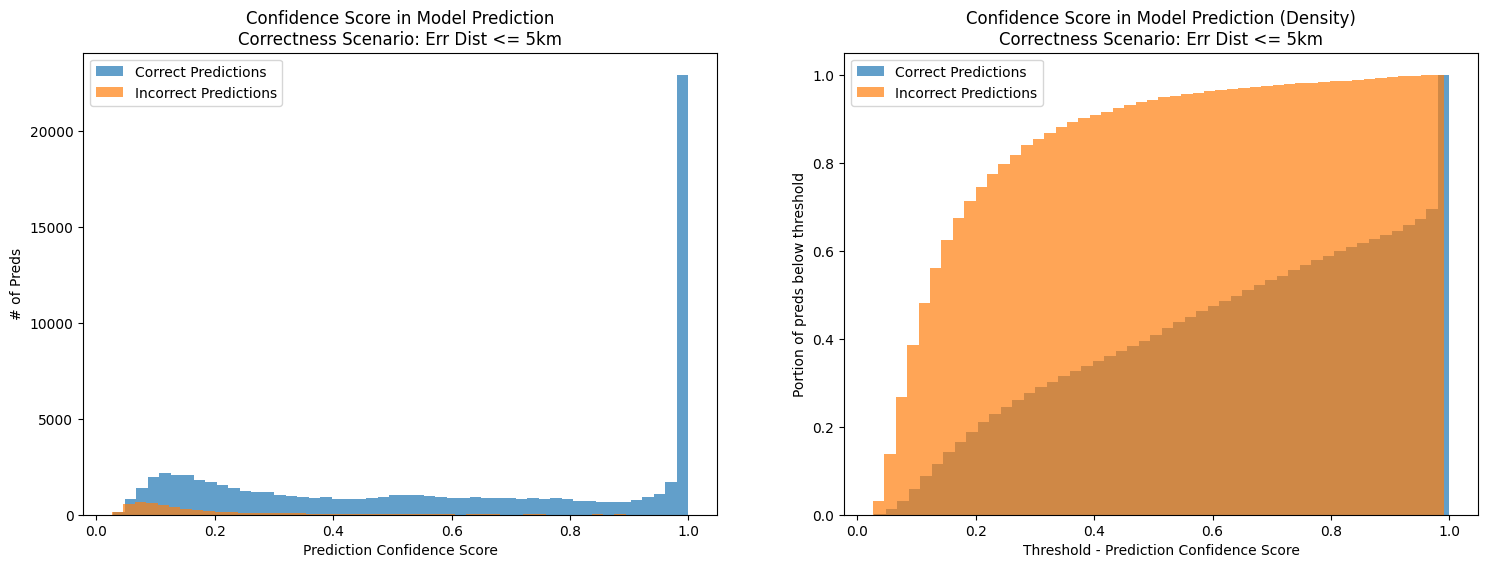

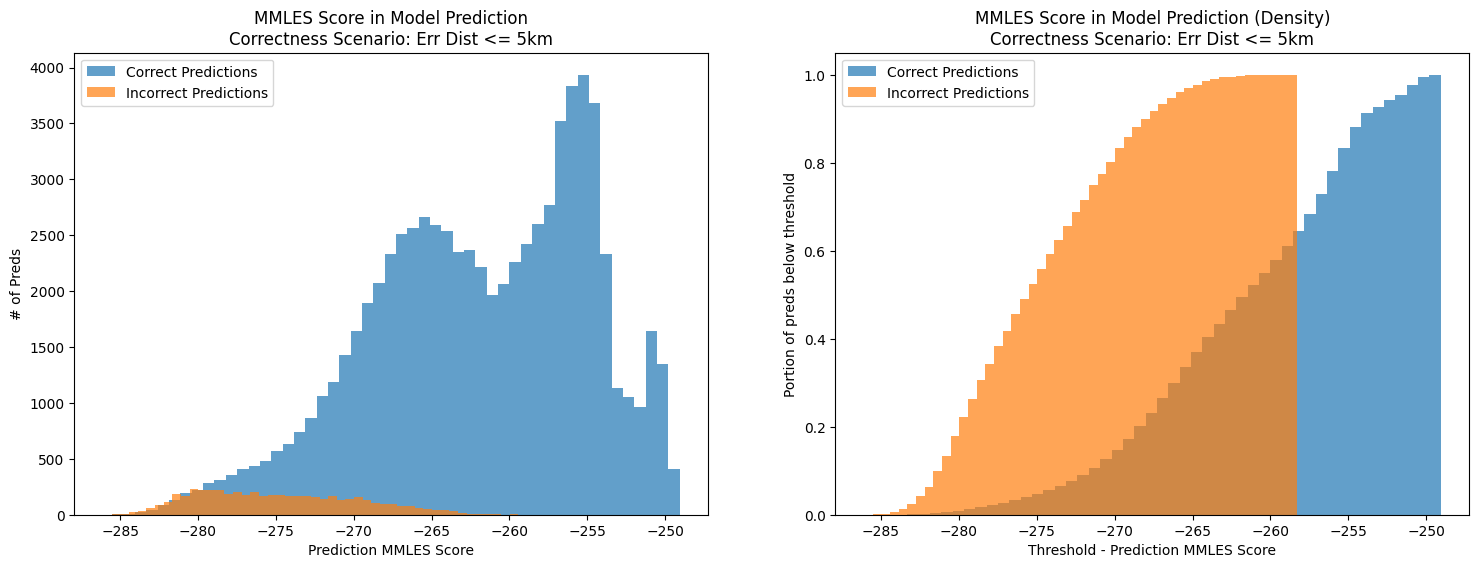

In [31]:
n_bins = 50
scenarios = [("Exact Cluster Match", is_correct)] + [(f"Err Dist <= {thresh_km}km", dist_err_km <= thresh_km) for thresh_km in (0.5, 1,2,3,5)]
for scenario_name, considered_correct in scenarios:
    for metric_name, metric in [("Confidence Score",  confidence), ("MMLES Score", mmles_scores)]:
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(1,2,1)
        ax.hist(metric[considered_correct], bins=n_bins, alpha=0.7, label="Correct Predictions")
        ax.hist(metric[np.invert(considered_correct)], bins=n_bins, alpha=0.7, label="Incorrect Predictions")
        ax.set_title(f"{metric_name} in Model Prediction\nCorrectness Scenario: {scenario_name}")
        ax.set_xlabel(f"Prediction {metric_name}")
        ax.set_ylabel("# of Preds")
        ax.legend()

        ax = fig.add_subplot(1,2,2)
        ax.hist(metric[considered_correct], bins=n_bins, density=True, cumulative=True, alpha=0.7, label="Correct Predictions")
        ax.hist(metric[np.invert(considered_correct)], bins=n_bins, density=True, cumulative=True, alpha=0.7, label="Incorrect Predictions")
        ax.set_title(f"{metric_name} in Model Prediction (Density)\nCorrectness Scenario: {scenario_name}")
        ax.set_xlabel(f"Threshold - Prediction {metric_name}")
        ax.set_ylabel("Portion of preds below threshold")
        ax.legend()
        plt.show()


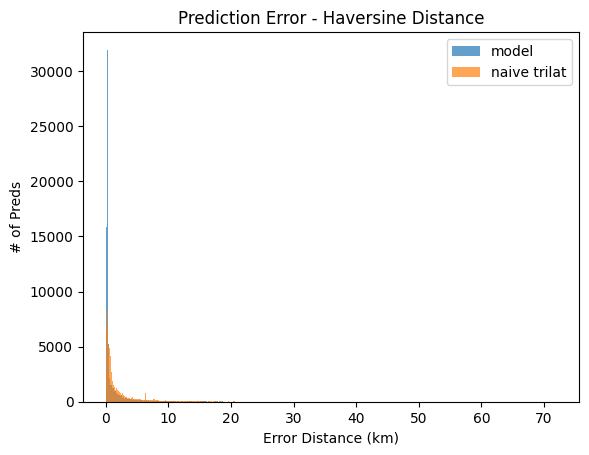

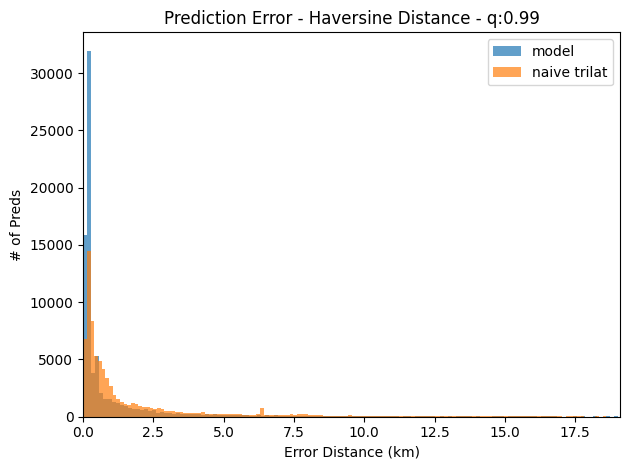

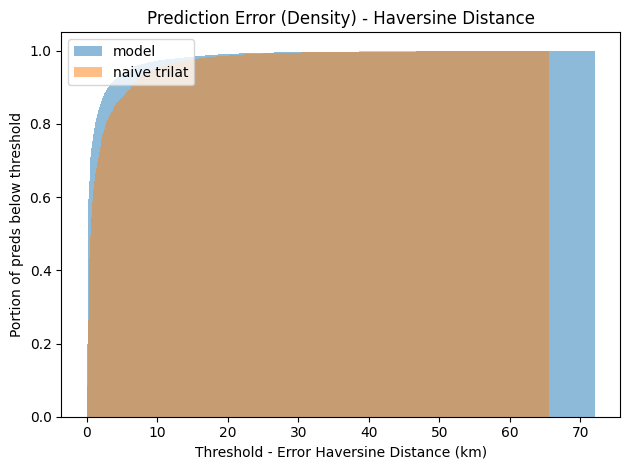

In [32]:
# Look at distribution:
n_bins = 500
plt.hist(dist_err_km, bins=n_bins, alpha=0.7, label="model")
plt.hist(naive_tri_dist_err_km, bins=n_bins, alpha=0.7, label="naive trilat")
plt.title("Prediction Error - Haversine Distance")
plt.xlabel("Error Distance (km)")
plt.ylabel("# of Preds")
# plt.tight_layout()
plt.legend()
plt.show()

# Zoom in
plt.figure()
plt.hist(dist_err_km, bins=n_bins, alpha=0.7, label="model")
plt.hist(naive_tri_dist_err_km, bins=n_bins, alpha=0.7, label="naive trilat")
plt.title("Prediction Error - Haversine Distance - q:0.99")
plt.xlim(0, np.quantile(dist_err_km, 0.99))
plt.xlabel("Error Distance (km)")
plt.ylabel("# of Preds")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.title("Prediction Error (Density) - Haversine Distance")
plt.hist(dist_err_km, bins=n_bins, alpha=0.5, density=True, cumulative=True, label="model")
plt.hist(naive_tri_dist_err_km, bins=n_bins, alpha=0.5, density=True, cumulative=True, label="naive trilat")
plt.xlabel("Threshold - Error Haversine Distance (km)")
plt.ylabel("Portion of preds below threshold")
plt.legend()
plt.tight_layout()
plt.show()